In [29]:
! pip install gymnasium[classic-control]
! mkdir logs
! mkdir plots

12535.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


12541.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


mkdir: cannot create directory ‘logs’: File exists


12546.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [5]:
#import ale_py
#import shimmy
import gymnasium as gym
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import random
import copy
import time
import pickle
import torchvision
import matplotlib.pyplot as plt
import math
import json

In [2]:

class CNN(nn.Module):

    def __init__(self):
        super().__init__()   
        self.linear1 = nn.Linear(4, 128)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(128,128)
        self.activation = nn.ReLU()
        self.linear3 = nn.Linear(128,2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        
        return x


In [7]:
class Memory():
    
    def __init__(self,size, prevent_forgetting=True):
        self.size = size
        self.experiences = []
        self.pop_index = 400 if prevent_forgetting else 0
        
    def sample(self,batch_size):
        return random.choices(self.experiences, k=batch_size)
        
    def add(self, experience):
        self.experiences.append(experience)
        if len(self.experiences) > self.size:
            self.experiences.pop(self.pop_index)
                    
    def __len__(self):
        return len(self.experiences)

In [4]:
class DQN_agent:


    def __init__(self, lr=0.0001 ,gamma=0.99, epsilon_params=(0.9,0.05,1000)):
        # Get cpu, gpu or mps device for training.
        self.device = (
            "cuda"
            if torch.cuda.is_available()
            else "mps"
            if torch.backends.mps.is_available()
            else "cpu"
        )
        print(f"Using {self.device} device")
        self.pred_NN = CNN().to(self.device)
        self.target_NN = copy.deepcopy(self.pred_NN)
        self.target_NN.eval()
        self.gamma = gamma
        self.epsilon_start = epsilon_params[0]
        self.epsilon_end = epsilon_params[1]
        self.epsilon_decay = epsilon_params[2]
        self.optimizer = torch.optim.AdamW(self.pred_NN.parameters(), lr=lr)
        self.steps_done = 0
        
    def predict(self, x):
        self.steps_done += 1
        return self.pred_NN.forward(x)
    
    def action(self, pred):
        eps = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * math.exp(-1. * self.steps_done / self.epsilon_decay)
        return (
            random.randint(0, pred.size(dim=0) - 1)
            if random.random() < eps
            else torch.argmax(pred).item()
        )
    
    def train(self, experience_batch):
        loss_fn = nn.SmoothL1Loss()
        epoch_loss = 0
        states = torch.stack([experience_batch[i][0] for i in range(len(experience_batch))])
        actions = torch.tensor([experience_batch[i][1] for i in range(len(experience_batch))])
        rewards = torch.tensor([experience_batch[i][2] for i in range(len(experience_batch))])#torch.tensor(experience_batch[:][2])
        next_states = torch.stack([experience_batch[i][3] for i in range(len(experience_batch))])
        terminated = torch.tensor([not experience_batch[i][4] for i in range(len(experience_batch))])
        y = self.estimated_value( rewards, next_states, terminated)
        self.optimizer.zero_grad()
        pred = self.pred_NN(states)
        indicies = torch.LongTensor(actions)
        indicies =indicies.unsqueeze(dim=0).T
        pred = pred.gather(1,indicies)
        loss = loss_fn(y, pred)
        loss.backward()
        self.optimizer.step()
        epoch_loss += loss.item()
        return epoch_loss
        
    def copy(self):
        self.target_NN.load_state_dict(self.pred_NN.state_dict())  
        
    def estimated_value(self, reward, next_state, done):
        with torch.no_grad():# vectorize it
                value_pred = self.target_NN.forward(next_state)
                action_pred = self.pred_NN.forward(next_state)
                action_id = torch.argmax(action_pred,1).unsqueeze(1)
                value = value_pred.gather(1,action_id)
                done = done.unsqueeze(1)
                target = reward + self.gamma * torch.mul(value,done)
        return target
        

In [8]:
#initialize environment
env = gym.make("CartPole-v1",render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, './videos', episode_trigger = lambda x: (x+1) % 100 == 0)
actions = range(env.action_space.n)

#hyperparams
max_steps = 9999
training_freq = 1
copying_freq = 40
batch_size = 128

#initialize agent
agent = DQN_agent(lr=0.0001)

training_session = 0
max_episode = 500

#loops until max_time is reached
memory = Memory(10000)
episodes = []
losses = []
total_steps = 0
logger = {"episodes":[],"losses":[]}
for episode  in range(1,max_episode):
    #get first states
    state, info = env.reset()
    #loops until experience_capacity is reached
    episode_reward = 0 
    episode_loss = 0
    steps = 0
    for i in range(1, max_steps):
        #predict q-values and choose action
        with torch.no_grad():
            pred = agent.predict(torch.tensor(state))
        action = agent.action(pred)
        #get next states
        next_state, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        if i == max_steps - 1:
            print("Max steps reached.")
        next_state = torch.from_numpy(next_state)
        experience = [torch.tensor(state), action, reward, torch.tensor(next_state), terminated] 
        memory.add(experience)
        if terminated or truncated:
            break
        state = next_state      
        if len(memory) > 500:
            experiences_train = memory.sample(batch_size)
            episode_loss += agent.train(experiences_train)
            training_session += 1
        steps = i
    if episode % 10 == 0:
        logger["episodes"].append(episodes)
        logger["losses"].append(losses)
        episodes = []
        losses = []
    episodes.append(episode_reward)
    losses.append(episode_loss/steps)
    if episode % copying_freq == 0:
        agent.copy()
    print(f"Episode: {episode} Reward: {episode_reward} loss: {episode_loss/steps}")
    
with open('logs/logger_ddqn.json', 'w') as fp:
    json.dump(logger, fp)

/home/konrad/Repos/NCML_project/rlenv/lib/python3.10/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:182: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/home/konrad/Repos/NCML_project/rlenv/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /home/konrad/Repos/NCML_project/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/tmp/ipykernel_27607/3443350587.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  experience = [torch.tensor(state), action, reward, torch.tensor(next_state), terminated]
/tmp/ipykernel_27607/3443350587.py:34: UserWarning: To copy construct from a tensor, it is recommended to 

Using cpu device
Episode: 1 Reward: 20.0 loss: 0.0
Episode: 2 Reward: 20.0 loss: 0.0
Episode: 3 Reward: 16.0 loss: 0.0
Episode: 4 Reward: 14.0 loss: 0.0
Episode: 5 Reward: 37.0 loss: 0.0
Episode: 6 Reward: 9.0 loss: 0.0
Episode: 7 Reward: 13.0 loss: 0.0
Episode: 8 Reward: 46.0 loss: 0.0
Episode: 9 Reward: 14.0 loss: 0.0
Episode: 10 Reward: 15.0 loss: 0.0
Episode: 11 Reward: 20.0 loss: 0.0
Episode: 12 Reward: 10.0 loss: 0.0
Episode: 13 Reward: 13.0 loss: 0.0
Episode: 14 Reward: 21.0 loss: 0.0
Episode: 15 Reward: 15.0 loss: 0.0
Episode: 16 Reward: 14.0 loss: 0.0
Episode: 17 Reward: 13.0 loss: 0.0
Episode: 18 Reward: 39.0 loss: 0.0
Episode: 19 Reward: 16.0 loss: 0.0
Episode: 20 Reward: 11.0 loss: 0.0
Episode: 21 Reward: 12.0 loss: 0.0
Episode: 22 Reward: 39.0 loss: 0.0
Episode: 23 Reward: 11.0 loss: 0.0
Episode: 24 Reward: 12.0 loss: 0.0
Episode: 25 Reward: 14.0 loss: 0.0
Episode: 26 Reward: 15.0 loss: 0.0
Episode: 27 Reward: 16.0 loss: 0.0
Episode: 28 Reward: 16.0 loss: 0.328851914405822

Moviepy - Done !
Moviepy - video ready /home/konrad/Repos/NCML_project/videos/rl-video-episode-99.mp4
Episode: 100 Reward: 10.0 loss: 0.10528725716802809


Episode: 101 Reward: 9.0 loss: 0.08972371136769652
Episode: 102 Reward: 12.0 loss: 0.08059448782693256
Episode: 103 Reward: 11.0 loss: 0.09652969688177108
Episode: 104 Reward: 10.0 loss: 0.09209679812192917
Episode: 105 Reward: 11.0 loss: 0.07901018895208836
Episode: 106 Reward: 10.0 loss: 0.09778774860832426
Episode: 107 Reward: 13.0 loss: 0.08225788113971551
Episode: 108 Reward: 12.0 loss: 0.07336842065507715
Episode: 109 Reward: 15.0 loss: 0.07674906163343362
Episode: 110 Reward: 10.0 loss: 0.07580861449241638
Episode: 111 Reward: 10.0 loss: 0.08090251684188843
Episode: 112 Reward: 8.0 loss: 0.09057282390339035
Episode: 113 Reward: 11.0 loss: 0.08201740495860577
Episode: 114 Reward: 9.0 loss: 0.08968033641576767
Episode: 115 Reward: 10.0 loss: 0.09492869095669852
Episode: 116 Reward: 11.0 loss: 0.08505964279174805
Episode: 117 Reward: 12.0 loss: 0.08105227249589833
Episode: 118 Reward: 10.0 loss: 0.08713812256852786
Episode: 119 Reward: 12.0 loss: 0.0845743478699164
Episode: 120 Rew

Moviepy - Done !
Moviepy - video ready /home/konrad/Repos/NCML_project/videos/rl-video-episode-199.mp4
Episode: 200 Reward: 29.0 loss: 0.13419893277542932
Episode: 201 Reward: 17.0 loss: 0.3016686113551259
Episode: 202 Reward: 20.0 loss: 0.22891514709121302


Episode: 203 Reward: 24.0 loss: 0.1808324154952298
Episode: 204 Reward: 50.0 loss: 0.16722446345553107
Episode: 205 Reward: 41.0 loss: 0.17508221194148063
Episode: 206 Reward: 24.0 loss: 0.15770031608965085
Episode: 207 Reward: 26.0 loss: 0.19424020558595656
Episode: 208 Reward: 36.0 loss: 0.15850822095360076
Episode: 209 Reward: 71.0 loss: 0.15856320911220143
Episode: 210 Reward: 64.0 loss: 0.1529815373203111
Episode: 211 Reward: 53.0 loss: 0.15805771832282728
Episode: 212 Reward: 62.0 loss: 0.15148668400332577
Episode: 213 Reward: 125.0 loss: 0.1383462810678588
Episode: 214 Reward: 71.0 loss: 0.15409177757267442
Episode: 215 Reward: 72.0 loss: 0.1430000377635301
Episode: 216 Reward: 107.0 loss: 0.1405168872256324
Episode: 217 Reward: 129.0 loss: 0.12874622877279762
Episode: 218 Reward: 125.0 loss: 0.13850045277767123
Episode: 219 Reward: 115.0 loss: 0.1348224985658338
Episode: 220 Reward: 100.0 loss: 0.12556907693582653
Episode: 221 Reward: 107.0 loss: 0.13353674191067805
Episode: 22

Moviepy - Done !
Moviepy - video ready /home/konrad/Repos/NCML_project/videos/rl-video-episode-299.mp4
Episode: 300 Reward: 165.0 loss: 0.026711077791732374
Episode: 301 Reward: 164.0 loss: 0.029173602863569157
Episode: 302 Reward: 149.0 loss: 0.033095590359644614
Episode: 303 Reward: 165.0 loss: 0.03216734626110382
Episode: 304 Reward: 167.0 loss: 0.029571496729012468
Episode: 305 Reward: 173.0 loss: 0.028671209686868933
Episode: 306 Reward: 188.0 loss: 0.029409740951888384
Episode: 307 Reward: 164.0 loss: 0.02966333185843952
Episode: 308 Reward: 234.0 loss: 0.03042845570161547
Episode: 309 Reward: 182.0 loss: 0.026740154328476894
Episode: 310 Reward: 184.0 loss: 0.028390335755949445
Episode: 311 Reward: 167.0 loss: 0.027703564653680828
Episode: 312 Reward: 158.0 loss: 0.028621815883177838
Episode: 313 Reward: 198.0 loss: 0.029677683102536646
Episode: 314 Reward: 176.0 loss: 0.026099323556159754
Episode: 315 Reward: 145.0 loss: 0.027601877998677082
Episode: 316 Reward: 199.0 loss: 0.0

Moviepy - Done !
Moviepy - video ready /home/konrad/Repos/NCML_project/videos/rl-video-episode-399.mp4
Episode: 400 Reward: 334.0 loss: 0.023197680514923914
Episode: 401 Reward: 215.0 loss: 0.03384879903397828
Episode: 402 Reward: 200.0 loss: 0.026831340165100945
Episode: 403 Reward: 196.0 loss: 0.021726021266882667
Episode: 404 Reward: 293.0 loss: 0.027840368529474316
Episode: 405 Reward: 178.0 loss: 0.02401069446061054
Episode: 406 Reward: 190.0 loss: 0.02726718250039359
Episode: 407 Reward: 209.0 loss: 0.02268421666863455
Episode: 408 Reward: 208.0 loss: 0.02298929793088121
Episode: 409 Reward: 270.0 loss: 0.022861099023944058
Episode: 410 Reward: 177.0 loss: 0.021909685537883142
Episode: 411 Reward: 214.0 loss: 0.026036358329805245
Episode: 412 Reward: 261.0 loss: 0.025883881690522404
Episode: 413 Reward: 194.0 loss: 0.023119385069666834
Episode: 414 Reward: 208.0 loss: 0.025044954594327047
Episode: 415 Reward: 383.0 loss: 0.022370979392380547
Episode: 416 Reward: 294.0 loss: 0.021

Text(0.5, 1.0, 'Loss')

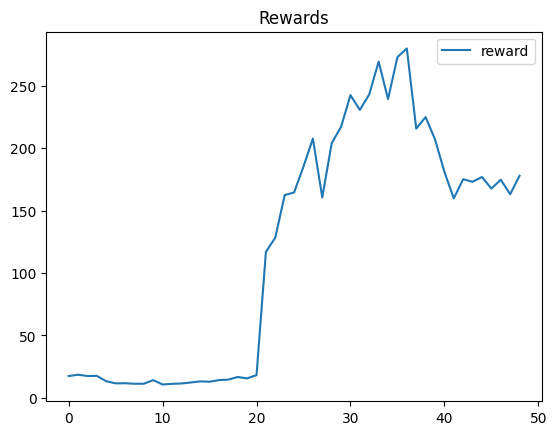

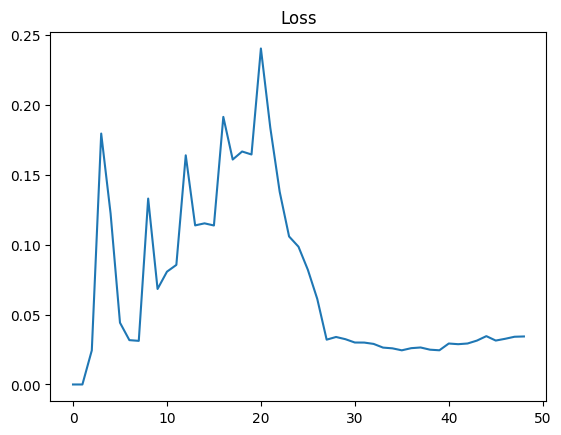

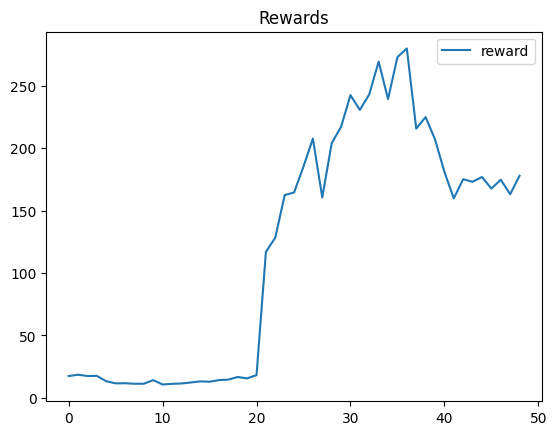

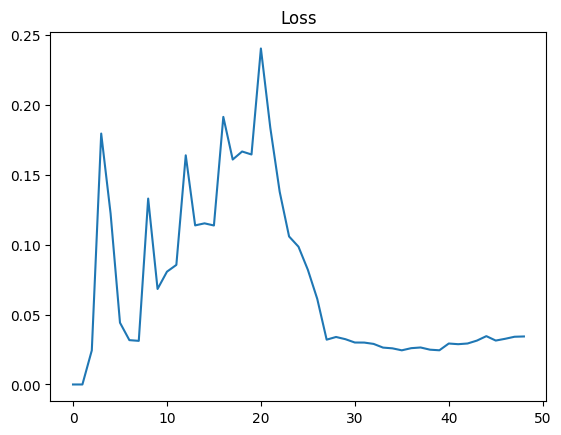

In [28]:
avg_rewards = [sum(rewards)/len(rewards) for rewards in logger["episodes"]]
avg_loss = [sum(losses)/len(losses) for losses in logger["losses"]]
plt.figure()
plt.plot(avg_rewards,label="reward")
plt.title("Rewards")
plt.legend()
plt.figure()
plt.plot(avg_loss)
plt.title("Loss")
import json

with open('logs/logger_ddqn.json', 'w') as fp:
    json.dump(logger, fp)
with open('logs/logger_ddqn.json', 'r') as fp:
    logger1 = json.load(fp)
avg_rewards = [sum(rewards)/len(rewards) for rewards in logger1["episodes"]]
avg_loss = [sum(losses)/len(losses) for losses in logger1["losses"]]
plt.figure()
plt.plot(avg_rewards,label="reward")
plt.title("Rewards")
plt.legend()
plt.figure()
plt.plot(avg_loss)
plt.title("Loss")

In [ ]:

print(f'*****stopped training after {elapsed_time} seconds*****\n')

print('*****Plot filters in first layer*****\n')
kernels = agent.pred_NN.stack[0].weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
filter_img = torchvision.utils.make_grid(kernels, nrow = 8)
plt.imshow(filter_img.permute(1, 2, 0))
plt.show() 

print('*****Pickle Dumping model*****\n')

file = open('safetyPickleDump', 'wb')
pickle.dump(agent, file)
file.close()

print("*****Saving model*****")
torch.save(agent.pred_NN.state_dict(), "model")

env.close()

In [192]:
A = [[1,2,3,4],[1,2,3,4],[1,2,3,4]]
A[0][:]

[1, 2, 3, 4]

In [72]:
A = torch.tensor([[1,2],[3,4],[5,6],[7,8]])
indicies = torch.LongTensor([0,1,0,1])
indicies =indicies.unsqueeze(dim=0).T

In [73]:
indicies

tensor([[0],
        [1],
        [0],
        [1]])

In [74]:
A.gather(1,indicies)

tensor([[1],
        [4],
        [5],
        [8]])